In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Advanced Lane Finding Project
---

## Camera calibration

In [2]:
def calibration(n=6, m=9):
    calibration_images = glob.glob("./camera_cal/*.jpg")
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image space
    #fig, axs = plt.subplots(5,4, figsize=(16, 11))
    #fig.subplots_adjust(hspace = .2, wspace=.001)
    #axs = axs.ravel()
    objp = np.zeros((n*m, 3), np.float32)
    objp[:,:2] = np.mgrid[0:m, 0:n].T.reshape(-1,2)
    #i = 0
    for cal_img in calibration_images:
        #i = i + 1
        img = mpimg.imread(cal_img)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (m,n), None)
        #img2 = cv2.drawChessboardCorners(img, (m,n), corners, ret)
        #axs[i].imshow(img2)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    
    img_size = (gray.shape[1], gray.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [3]:
def plot(img, converted, title1='Original', title2='Converted', cmap="gray", flag1=False, flag2=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(converted, cmap=cmap)
    ax2.set_title(title2, fontsize=30)
    
    if flag1 == True:
        mpimg.imsave("output_images/" + title1, img, format="jpg")
    if flag2 == True:
        mpimg.imsave("output_images/" + title2, converted, format="jpg")

In [ ]:
#mtx, dist = calibration()

In [ ]:
#calibration = {}
#calibration["mtx"] = mtx
#calibration["dist"] = dist
#pickle.dump( calibration, open( "calibration.p", "wb" ) )

In [4]:
calibration = pickle.load(open( "calibration.p", "rb" ))

In [5]:
mtx = calibration["mtx"]
dist = calibration["dist"]

## example calibration

In [6]:
def cal_example():
    img = mpimg.imread("./camera_cal/calibration2.jpg")
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    (n, m) = (6,9)
    ret, corners = cv2.findChessboardCorners(gray, (m,n), None)
    img2 = cv2.drawChessboardCorners(img, (m,n), corners, ret)
    dst = undistort(img, mtx, dist)
    return img2, dst

img2, dst = cal_example()

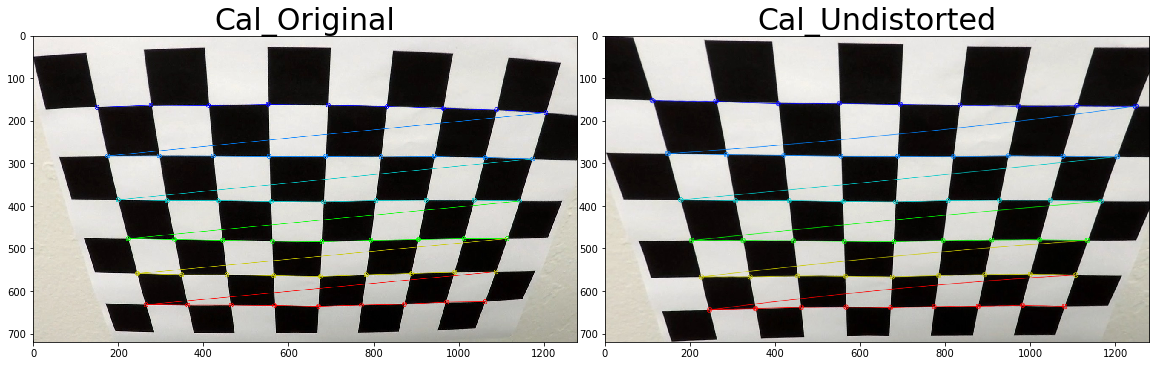

In [7]:
plot(img2, dst, 'Cal_Original', 'Cal_Undistorted', flag1=True, flag2=True)

## test image

In [8]:
img = mpimg.imread("./test_images/test4.jpg")

In [9]:
dst = undistort(img, mtx, dist)

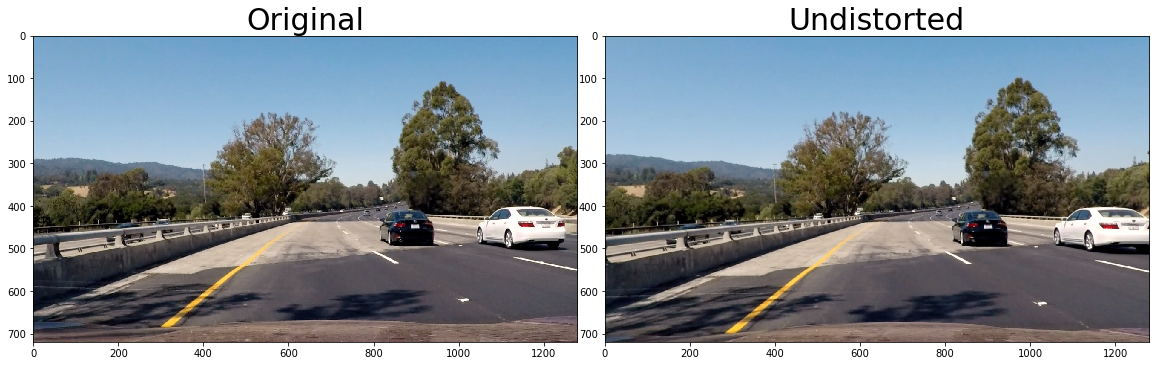

In [10]:
plot(img, dst, 'Original', 'Undistorted', flag1=True, flag2=True)

In [11]:
def perspective_matrices(img):
    n, m = img.shape[:-1]
    # top-left top-right bottom-right bottom-left
    src = np.array([ [550, 450], [750,450], [1200, 700], [100, 700] ], dtype='float32')
    ofs = 0 # offset for dst points
    dst = np.array([ [ofs, ofs], [m, ofs], [m, n], [ofs, n] ], dtype='float32')
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

In [12]:
M, Minv = perspective_matrices(dst)

In [13]:
def perspective(img, M):
    n, m = img.shape[:-1]
    warped = cv2.warpPerspective(img, M, (m,n), flags=cv2.INTER_LINEAR)
    return warped

In [14]:
warped = perspective(dst, M)

In [15]:
dst_copy = dst.copy()

In [16]:
top_left = (550, 450)
top_right = (750,450)
bottom_right = (1200, 700)
bottom_left = (100, 700)

In [17]:
# bottom
dst_copy = cv2.line(dst_copy, bottom_left, bottom_right, color=[255,0,0], thickness=6)
# top
dst_copy = cv2.line(dst_copy, top_left, top_right, color=[255,0,0], thickness=6)
# right
dst_copy = cv2.line(dst_copy, top_right, bottom_right, color=[255,0,0], thickness=6)
# left
dst_copy = cv2.line(dst_copy, bottom_left, top_left, color=[255,0,0], thickness=6)

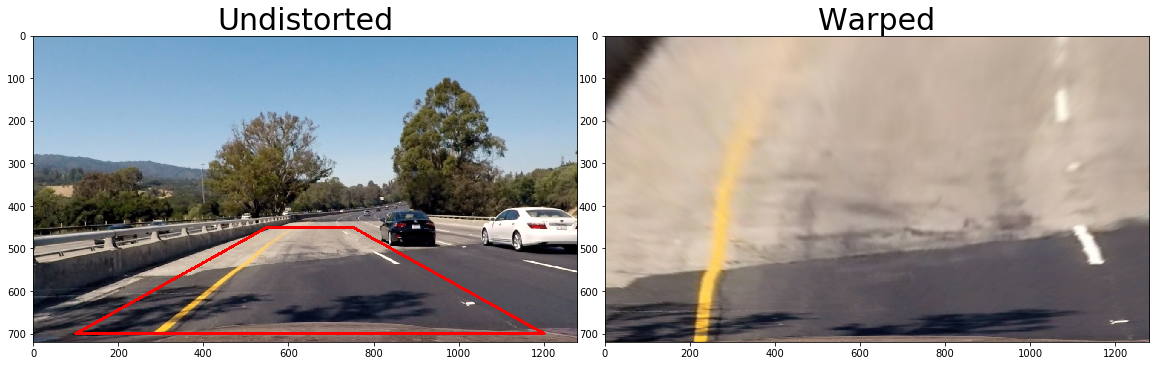

In [18]:
plot(dst_copy, warped, 'Undistorted', 'Warped', flag1=True, flag2=True)

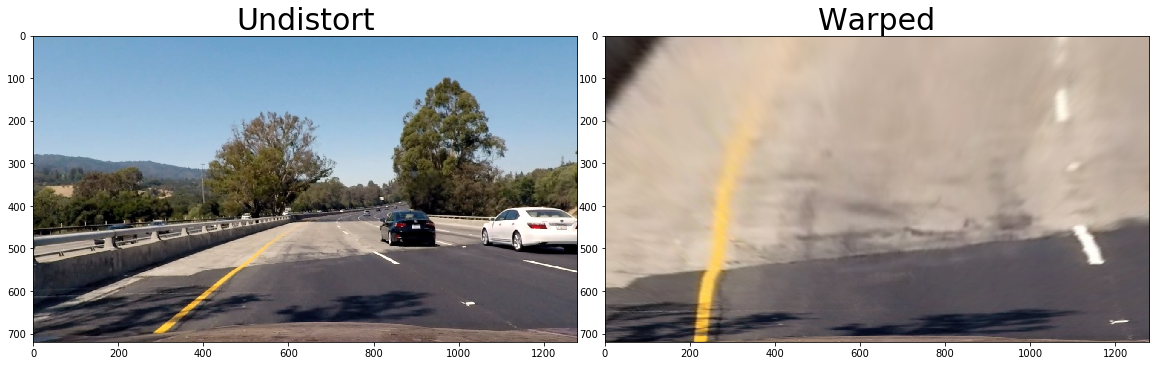

In [19]:
plot(dst, warped, 'Undistort', 'Warped')

## gradient & color thresholding

In [20]:
def region(img, vertices):
    
    mask = np.zeros_like(img)   
    mask_color = 255
    cv2.fillPoly(mask, vertices, mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [21]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def hsvscale(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return hsv

def hlsscale(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def labscale(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    return lab

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def sobel_thresh(img, sobel_kernel=5, flag="x", thresh_min=0, thresh_max=255):
    gray = grayscale(img)    
    if flag == "x":
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobel = np.absolute(sobelx)
    elif flag == "y":
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobel = np.absolute(sobely)
    ## magnitude
    elif flag == "m":
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        sobel = np.sqrt(sobelx**2 + sobely**2)
    ## direction
    elif flag == "d":
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        direction = np.arctan2(abs_sobely, abs_sobelx)
    
    if flag != "d":
        scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    else:
        scaled_sobel = direction
        
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel > thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return mask

def color_thresh(img, flag="s", thresh_min=0, thresh_max=255):
    
    hls = hlsscale(img)
    lab = labscale(img)
    if flag == "s":
        channel = hls[:,:,2]
    elif flag == "l":
        channel = lab[:,:,0]
    elif flag == "g":
        channel = grayscale(img)
    
    scaled_channel = channel[:]#np.uint8(255*channel/np.max(channel))
    mask = np.zeros_like(scaled_channel)
    mask[(scaled_channel > thresh_min) & (scaled_channel <= thresh_max)] = 1
    return mask

In [22]:
gauss = gaussian_blur(warped, 5)

In [23]:
thresh = sobel_thresh(gauss, flag="x", thresh_min=30, thresh_max=255)

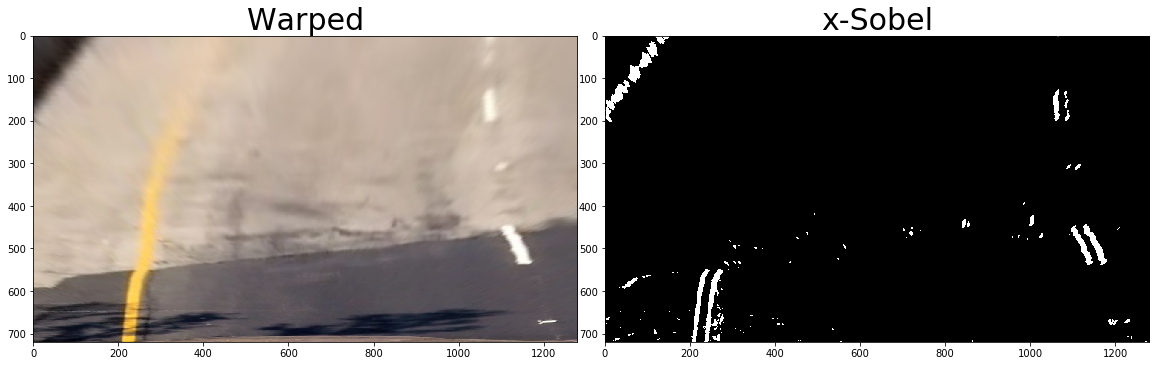

In [24]:
plot(warped, thresh, 'Warped', 'x-Sobel', flag2=True)

In [25]:
color_l = color_thresh(gauss, "l", thresh_min=210, thresh_max=255)

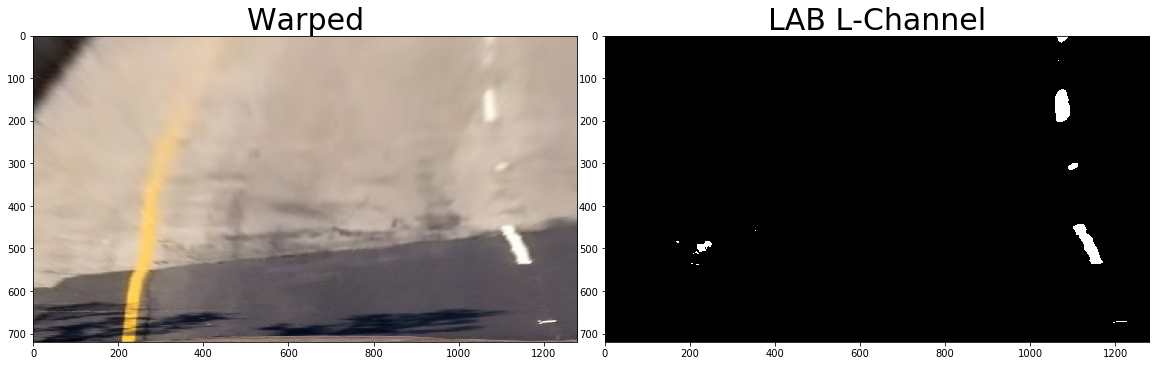

In [26]:
plot(warped, color_l, 'Warped', 'LAB L-Channel', flag2=True)

In [27]:
color_s = color_thresh(gauss, "s", thresh_min=120, thresh_max=255)

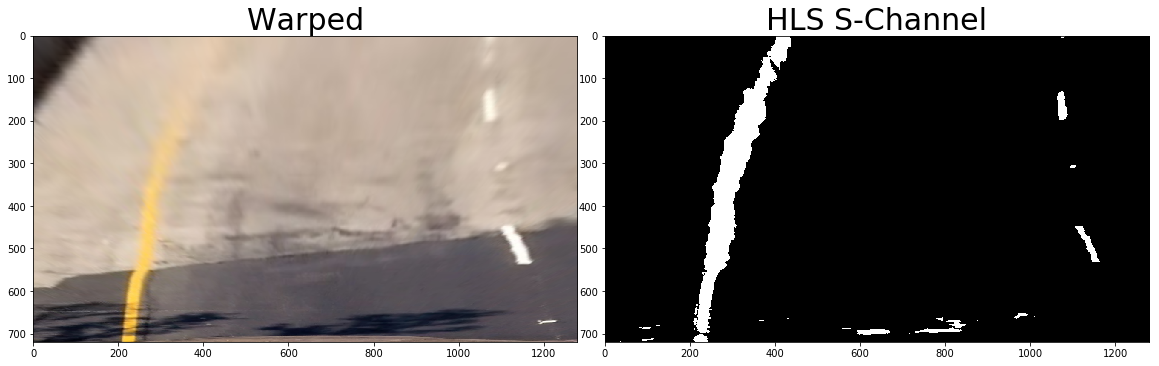

In [28]:
plot(warped, color_s, 'Warped', 'HLS S-Channel', flag2=True)

In [29]:
combined = np.zeros_like(color_l)
combined[ (color_l == 1) | (color_s == 1) | (thresh == 1) ] = 1

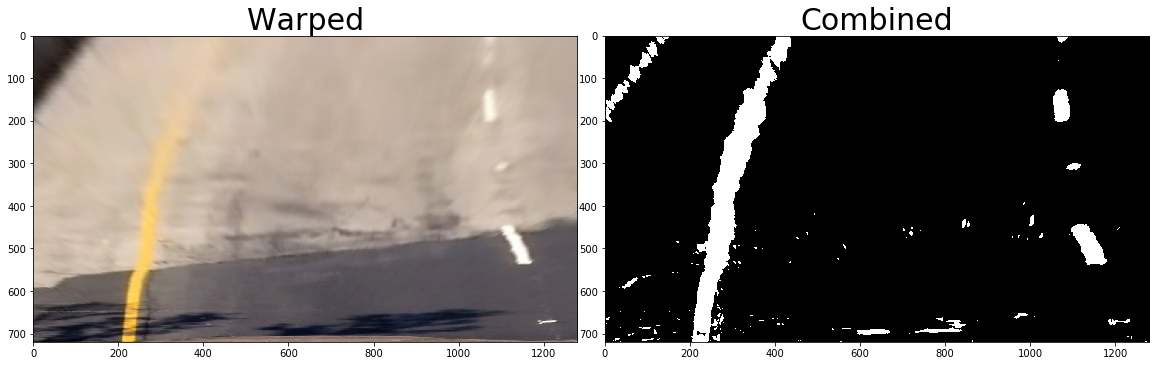

In [30]:
plot(warped, combined, 'Warped', 'Combined', flag2=True)

## build pipeline

In [31]:
def starting_centers(image):
    n, m = image.shape[:2]
    ofs = m // 2
    
    left_center = None
    right_center = None
    
    hist = np.sum(image[n//2:], axis=0)
    t = hist.shape[0]//4
    
    left_hist = hist[:t]
    if len(left_hist) != 0:
        left_center = left_hist.argmax()
    
    right_hist = hist[(ofs + t):]
    if len(right_hist) != 0:
        right_center = right_hist.argmax() + (ofs + t)
    
    return (left_center, right_center)

In [32]:
def window_routine(image, center, height_win, t, k=100, flag=False):
    
    bottom_left = ((-k + center), (height_win*t))
    bottom_right = ((center + k), (height_win*t))
    upper_left = ((-k + center), (height_win)*(t+1))
    upper_right = ((center + k), (height_win)*(t+1))
    
    if flag == True:
        cv2.rectangle(gauss,bottom_left,upper_right,(0,0,255), 6) 
    
    win = image[(height_win*t):((height_win)*(t+1)), (-k + center):(center + k)]
    return win

In [33]:
def windows_compute(win, line, old_center, height_win, t, k=100, flag=False):
    
    line_w = win.nonzero()
    hist = np.sum(win, axis=0)
    
    if len(hist) == 0:
        return old_center, line
    
    center = hist.argmax()
    minpix = 50
    if len(line_w[0]) > minpix:
        new_center = old_center  + (center - k)
    else:
        new_center = old_center
    line[0].extend(line_w[1] + (-k + old_center))
    line[1].extend(line_w[0] + (height_win)*(t))
    
    if flag == True:
        cv2.line(gauss, (new_center, (height_win)*(t)), (new_center, (height_win)*(t+1)), (255,0,0), 6)
    return new_center, line

In [34]:
def detect_lines(image, left_center_old, right_center_old):
    
    n, m = image.shape[:2]
    n_windows = 8
    height_win = n // n_windows
    
    line_left = [[], []]
    line_right = [[], []]
    radius_left = []
    radius_right = []
    xl = []
    yl = []
    xr = []
    yr = []
    
    left_center, right_center = starting_centers(image)
    
    if left_center == None and right_center == None:
        xl, yl, xr, yr, radius_left, radius_right, left_center, right_center
    
    if left_center == None:
        left_center = left_center_old
    
    left_center_start = left_center
        
    if right_center == None:
        right_center = right_center_old
        
    right_center_start = right_center
    
    for t in range((n_windows-1),-1, -1):
        win_left = window_routine(image, left_center, height_win, t, flag=True)
        win_right = window_routine(image, right_center, height_win, t, flag=True)
        
        left_center, line_left = windows_compute(win_left, line_left, left_center, height_win, t, flag=True)
        right_center, line_right = windows_compute(win_right, line_right, right_center, height_win, t, flag=True)
    
    left_x = np.array(line_left[0], dtype="int32")
    left_y = np.array(line_left[1], dtype="int32")
    yl = np.linspace(0,n)
    
    ym_per_pix = 30/720 # meters per pixel
    xm_per_pix = 3.7/700
    
    if len(left_x) > 10:
    
        left_fit = np.polyfit(left_y, left_x, 2)
        xl = left_fit[2] + left_fit[1]*yl + left_fit[0]*yl**2
        
        left_fit_radius = np.polyfit( (left_y * ym_per_pix), (left_x * xm_per_pix), 2)
        radius_left = (1 + (2 * left_fit_radius[0] * (yl * ym_per_pix) + left_fit_radius[1])**2) * (3/2) / (2 * left_fit_radius[0])
        
        xl = xl.astype("int32")
        yl = yl.astype("int32")
        
    right_x = np.array(line_right[0], dtype="int32")
    right_y = np.array(line_right[1], dtype="int32")
    yr = np.linspace(0,n)
    
    if len(right_x) > 10:
        
        right_fit = np.polyfit(right_y, right_x, 2)
        xr = right_fit[2] + right_fit[1]*yr + right_fit[0]*yr**2
        
        right_fit_radius = np.polyfit( (right_y * ym_per_pix), (right_x * xm_per_pix), 2)
        radius_right = (1 + (2 * right_fit_radius[0] * (yr * ym_per_pix) + right_fit_radius[1])**2) * (3/2) / (2 * right_fit_radius[0]) 
        
        xr = xr.astype("int32")
        yr = yr.astype("int32")
    
    return xl, yl, xr, yr, radius_left, radius_right, left_center_start, right_center_start

In [35]:
xl, yl, xr, yr, rl, rr, left_center_start, right_center_start = detect_lines(combined, 285, 1150)

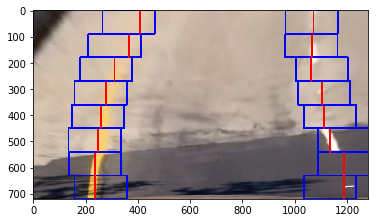

In [36]:
plt.imshow(gauss, cmap="gray")
mpimg.imsave("output_images/" + "lines_win", gauss, format="jpg")
plt.show()

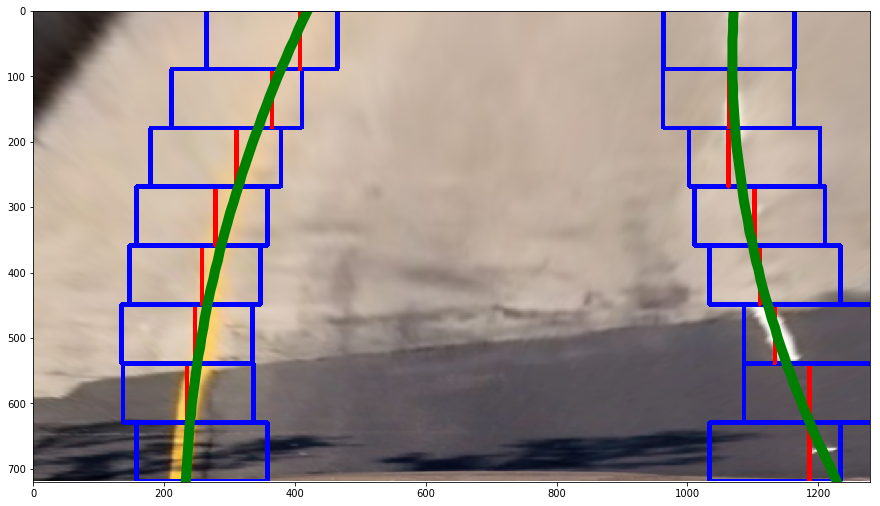

In [37]:
plt.figure(figsize=(15, 15))
plt.imshow(gauss, cmap="gray")
plt.plot(xl, yl, color="green", linewidth=10)
plt.plot(xr, yr, color="green", linewidth=10)
plt.ylim(720,0)
plt.savefig("output_images/lines_win_fit.jpg", bbox_inches='tight', dpi=200)

In [38]:
def f_thresh(gauss):
    
    thresh = sobel_thresh(gauss, flag="x", thresh_min=30, thresh_max=255)
    color_l = color_thresh(gauss, "l", thresh_min=210, thresh_max=255)
    color_s = color_thresh(gauss, "s", thresh_min=120, thresh_max=255)
    combined = np.zeros_like(color_l)
    combined[ (color_l == 1) | (color_s == 1) | (thresh == 1) ] = 1
    return combined

In [39]:
def pipeline(dst, left_center_old=285, right_center_old=1150, flag=False):
    
    M, Minv = perspective_matrices(dst)
    warped = perspective(dst, M)
    gauss = gaussian_blur(warped, 5)
    combined = f_thresh(gauss)
    
    xl, yl, xr, yr, radius_left, radius_right, left_center_start, right_center_start = detect_lines(combined,
                                                                                                    left_center_old, 
                                                                                                    right_center_old)
    rl = radius_left[len(radius_left)//2]
    rr = radius_right[len(radius_right)//2]
    
    ofs = img.shape[1] // 2
    position = (right_center_start + left_center_start)/2 - ofs
    xm_per_pix = 3.7/700
    position_m = position * xm_per_pix
    
    if flag==True:
        return gauss, xl, yl, xr, yr, rl, rr, left_center_start, right_center_start, position_m, Minv
    else:
        return xl, yl, xr, yr, rl, rr, left_center_start, right_center_start, position_m, Minv

In [40]:
xl, yl, xr, yr, rl, rr, left_center_start, right_center_start, position, Minv = pipeline(img)

In [41]:
def draw(img, xl, yl, xr, yr, rl, rr, position, Minv, flag=True):
    new_img = np.copy(img)
    
    color_warp = np.zeros_like(new_img).astype(np.uint8)
    h, w = warped.shape[:2]
    
    if xl is not []:
        pts_left = np.array([np.transpose(np.vstack([xl, yl]))])
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=15)
        
    if xr is not []:
        pts_right = np.array([np.flipud(np.transpose(np.vstack([xr, yr])))])
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
    
    if xl is not [] and xr is not []:
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
    
    radius = (rl + rr) / 2
    if flag == True:
        font = cv2.FONT_HERSHEY_DUPLEX
        text = 'radius curvature: ' + '{:04.1f}'.format(radius) + 'm'
        cv2.putText(new_img, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
        text = 'distance center: ' + '{:01.2f}'.format(position) + 'm'  
        cv2.putText(new_img, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    
    result = cv2.addWeighted(new_img, 1, newwarp, 0.4, 0)
    return result

In [42]:
files = os.listdir("./test_images/")

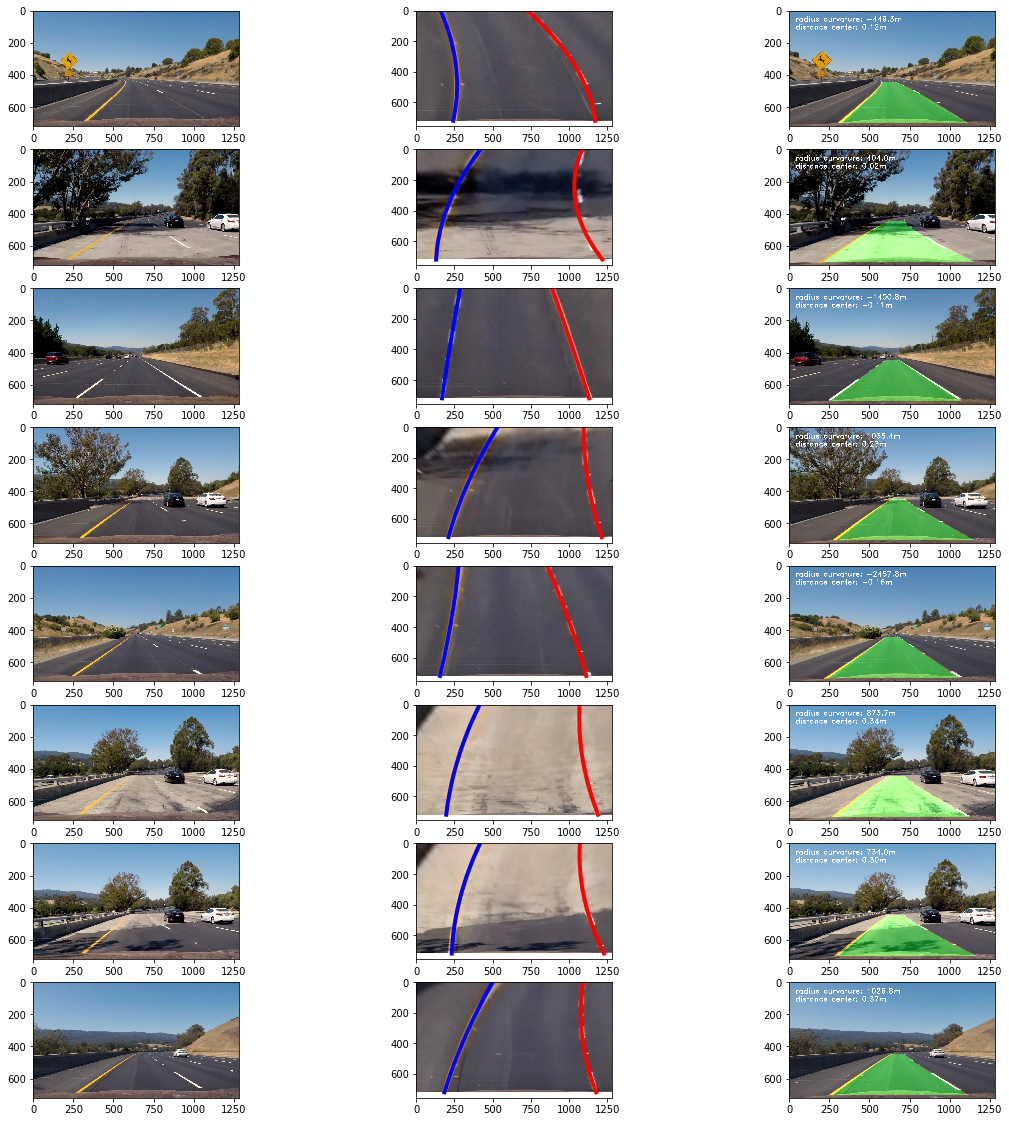

In [43]:
fig, axs = plt.subplots(len(files), 3, figsize=(20,20))
fig.subplots_adjust(hspace = .2, wspace=.05)

for f in range(len(files)):
    file = files[f]
    image = mpimg.imread("./test_images/" + file)
    dst = undistort(image, mtx, dist)
    warped, xl, yl, xr, yr, rl, rr, left_center_start, right_center_start, position, Minv = pipeline(dst, flag=True)
    result = draw(dst, xl, yl, xr, yr, rl, rr, position, Minv)
    
    axs[f, 0].imshow(image)
    axs[f, 1].imshow(warped, cmap="gray")
    axs[f, 1].plot(xl, yl, color="blue", linewidth=4)
    axs[f, 1].plot(xr, yr, color="red", linewidth=4)
    axs[f, 2].imshow(result)
    mpimg.imsave("output_images/" + file, result, format="jpg")

In [44]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.logic = False  
        
        self.stack_x = [] 
        self.x = None
        self.x_old = None
        
        self.stack_radius = [] 
        self.radius = None 
        
        self.stack_position = []
        self.position = None 
        
        self.dist = 0
    
    def detected(self, x):
        if x is not []:
            self.logic = True
        else:
            self.logic = False
            
    def max_distance(self, x):
        if self.x_old != None:
            dist = abs(x - self.x_old) / self.x_old
            dist = sum(dist) / len(dist)
            self.dist = dist
        else:
            self.dist = 0
            
    def update(self, x, y, radius, position, t=10, limit=0.25):
        self.detected(x)
        self.max_distance(x)
        if self.logic:
            if self.dist < limit:
                if len(self.stack_x) > t:
                    self.stack_x.pop(0)
                    self.stack_radius.pop(0)
                    self.stack_position.pop(0)

                self.stack_x.append(x)
                self.x = np.mean(self.stack_x, axis=0)
                self.x_old = self.x[:]

                self.stack_radius.append(radius)
                self.radius = np.mean(self.stack_radius, axis=0)

                self.stack_position.append(position)
                self.position = np.mean(self.stack_position, axis=0)

In [45]:
left_line = Line()
right_line = Line()

def process_image(image):
    new_image = image.copy()
    h, w = new_image.shape[:2]
    
    dst = undistort(new_image, mtx, dist)
    xl, yl, xr, yr, rl, rr, cl, cr, p, Minv = pipeline(dst)
    
    left_line.update(xl, yl, rl, p)
    right_line.update(xr, yr, rr, p)
    
    av_xl = left_line.x
    av_xr = right_line.x
    av_rl = left_line.radius
    av_rr = right_line.radius
    av_p = left_line.position
    
    result = draw(dst, av_xl, yl, av_xr, yr, av_rl, av_rr, av_p, Minv)
    return result

In [46]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [47]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('./videos/project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:05<00:00,  1.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 15s, sys: 1min 54s, total: 10min 10s
Wall time: 7min 10s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

In [ ]:
# video_output2 = 'challenge_video_output.mp4'
# video_input2 = VideoFileClip('./videos/challenge_video.mp4')
# processed_video = video_input2.fl_image(process_image)
# %time processed_video.write_videofile(video_output2, audio=False)

In [ ]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(video_output2))

In [ ]:
# video_output3 = 'harder_challenge_video_output.mp4'
# video_input3 = VideoFileClip('harder_challenge_video.mp4')
# processed_video = video_input2.fl_image(process_image)
# %time processed_video.write_videofile(video_output3, audio=False)